In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats
import pickle

In [2]:
# Carregando o data frame
df = pd.read_excel('../data/preprocessed.xlsx', index_col=0)

#### VAR_2
- A = 0
- B = 1
- C = 2

In [6]:
# Pegando apens os registros dentro da qualidade
df_qualidade = df[df['QUALIDADE'] == 0]
df_qualidade

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,QUALIDADE
3,263.92,2.36,2,9.900123,0
7,274.96,2.33,2,9.607203,0
8,227.67,2.45,2,9.036513,0
10,262.60,2.85,2,9.826068,0
11,319.19,2.34,1,9.963041,0
...,...,...,...,...,...
485,270.65,2.63,1,9.873261,0
490,286.34,2.28,1,9.494521,0
491,227.09,2.63,1,9.305761,0
494,259.67,2.91,2,9.992756,0


In [15]:
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())

def calc_metrics(ytest, ypred):
    # Calculate the absolute errors
    errors = abs(ypred - ytest)
    #Avaliando modelo com dados de teste
    r2 = r2_score(ytest,ypred)
    rss = calc_rss(ytest,ypred)
    meanabs = mean_absolute_error(ytest,ypred)

    # mean absolute percentage error (MAPE)
    mape = 100 * (errors / ytest)
    #accuracy
    accuracy = 100 - np.mean(mape)

    print('Accuracy:', round(accuracy, 2), '%.')
    print("R2 score: {:.3f}".format(r2))
    print("RSS score: {:.3f}".format(rss))
    print("Mean absolute error: {:.3f}".format(meanabs))
    
def plot_resid(ytest, ypred, ytrain, ypred_train):
    plt.scatter(ypred_train, ypred_train - ytrain,
                color = "green", s = 10, label = 'Train data')
    plt.scatter(ypred, ypred - ytest,
                color = "blue", s = 10, label = 'Test data')

    ## plotting line for zero residual error
    plt.hlines(y = 0, xmin = np.min(ypred_train), xmax = np.max(ypred_train), linewidth = 2)
    plt.legend(loc = 'upper right')
    plt.title("Residual errors")
    plt.show()

In [19]:
df_qualidade.iloc[:, 1:3]

,VAR_1,VAR_2
3,2.36,2
7,2.33,2
8,2.45,2
10,2.85,2
11,2.34,1
...,...,...
485,2.63,1
490,2.28,1
491,2.63,1
494,2.91,2


In [61]:
# Criando objetos de treino e teste
X = df_qualidade.iloc[:, 1:3].values
y = df_qualidade['QTD_CHOC'].values

# Criando dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Imprimindo os resultados
print("{0:0.2f}% nos dados de treino".format((len(X_train)/len(df_qualidade.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X_test)/len(df_qualidade.index)) * 100))

69.49% nos dados de treino
30.51% nos dados de teste


In [87]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=3)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [88]:
calc_metrics(y_test,rf.predict(X_test))

Accuracy: 92.86 %.
R2 score: 0.543
RSS score: 22147.225
Mean absolute error: 19.095


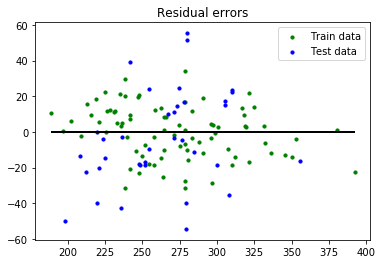

In [84]:
# Residual error
plot_resid(y_test, rf.predict(X_test),y_train, rf.predict(X_train))

### Preenchendo sem modelo, apenas com analise dos dados

- Preenchendo a coluna QTD_CHOC com os valores ótimos encontrados
- Não foi utilizado modelo, pois apresentou um erro absoluto medio grande
- Foi feito análise dos dados para identificar o valor ótimo

1 - Separando apenas os registros com qualidade dentro do padrão

2 - Agrupando pela coluna VAR_2 e vendo a média do valor de QTD_CHOC

3 - Agrupando pela coluna VAR_1 porém arredondada para ter apenas 3 valores únicos

4 - Pegando os valores ótimos do agrupamento VAR_2 e VAR_1 e tirando a média

In [96]:
#Agrupando pela coluna VAR_2
df_var2 = df_qualidade.groupby(['VAR_2']).mean()
df_var2

,QTD_CHOC,VAR_1,PESO_BOMBOM,QUALIDADE
VAR_2,,,,
0,297.325000,0.981667,9.603972,0
1,293.161887,2.149057,9.498093,0
2,247.035254,2.516102,9.595986,0


In [98]:
df_qualidade['VAR_1_ROUN'] = round(df_qualidade['VAR_1'])
df_var1 = df_qualidade.groupby(['VAR_1_ROUN']).mean()
df_var1

C:\Users\kemxim\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,QUALIDADE
VAR_1_ROUN,,,,,
0.0,343.875000,0.240000,0.500000,9.203937,0.0
1.0,326.617000,1.121000,0.600000,9.452070,0.0
2.0,281.328667,2.175500,1.433333,9.521664,0.0
3.0,240.499348,2.739565,1.695652,9.629511,0.0


In [95]:
np.mean([247.035254,240.499348])

243.767301

In [105]:
df_var1['QTD_CHOC']

VAR_1_ROUN
0.0    343.875000
1.0    326.617000
2.0    281.328667
3.0    240.499348
Name: QTD_CHOC, dtype: float64

In [106]:
# Carregando o data frame
df_pred = pd.read_excel('../data/analise-prescritiva.xlsx')
df_pred_copy = df_pred.copy()
df_pred_copy.loc[:,'VAR_2'] = df_pred.loc[:,'VAR_2'].astype('category').cat.codes
df_pred_copy['VAR_1_ROUN'] = round(df_pred_copy['VAR_1'])

df_pred_copy.head()

,QTD_CHOC,VAR_1,VAR_2,VAR_1_ROUN
0,NaN,2.07,2,2.0
1,NaN,2.94,1,3.0
2,NaN,2.53,1,3.0
3,NaN,2.19,1,2.0
4,NaN,2.02,2,2.0


In [122]:
df_pred.loc[0]['QTD_CHOC']

nan

In [134]:
def best_value(var1,var2):
    value_var1 = df_var1['QTD_CHOC'][var1]
    value_var2 = df_var2['QTD_CHOC'][var2]
    best_value = np.mean([value_var1,value_var2])
    return best_value

In [135]:
df_pred['QTD_CHOC'] = df_pred_copy.apply(lambda row: best_value(row['VAR_1_ROUN'], row['VAR_2']), axis=1)

In [136]:
df_pred

,QTD_CHOC,VAR_1,VAR_2
0,264.181960,2.07,C
1,266.830617,2.94,B
2,266.830617,2.53,B
3,287.245277,2.19,B
4,264.181960,2.02,C
5,309.889443,0.98,B
6,311.971000,1.04,A
7,311.971000,1.32,A
8,287.245277,1.97,B
9,289.326833,1.82,A


In [137]:
df_pred.to_excel("../data/analise-prescritiva-resultado.xlsx", index=False)  